In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__budget.sample import sample_budget_alternative_customers
from ml_simulation__budget.data import get_budget_alternative_compute_function
from ml_simulation__budget.widget import show_budget_alternative_widget
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

In [6]:
# Sampling
sample_seed = int(time.time() * 1000) % 10000000
print(sample_seed)
selected_ids = sample_budget_alternative_customers(df_sim, random_state=sample_seed)

191688
Non-converted customers: 923
Products with price data: 9

📊 PRODUCT PRICE TIERS (from simulation pool):
                         product  count       p30       p70       p90
                       Chaudière    411  3646.800  5398.340  7688.060
                           Poêle    292  4938.600  6300.307  7573.243
                 Pompe à chaleur    197 12546.528 15726.256 18570.966
                   Climatisation    191  3816.500  6849.280 11113.260
ECS : Chauffe-eau ou adoucisseur     46  1380.105  2830.515  3603.930
                  Photovoltaïque     35  7565.466 10289.626 13560.080
                          Autres      9  1330.800  6100.760  7918.098
                     Produit VMC      8  2378.767  5365.288 19652.460
                Appareil hybride      7 14456.038 14773.304 15262.136
🎯 MID-RANGE candidates (p30–p70): 357

🎯 SELECTED BUDGET ALTERNATIVE CANDIDATES:
customer_id          product    price      tier  quote_count  budget_price  savings_pct
 CL00345201    Clima

Initialized Simulation with 5 sampled IDs.


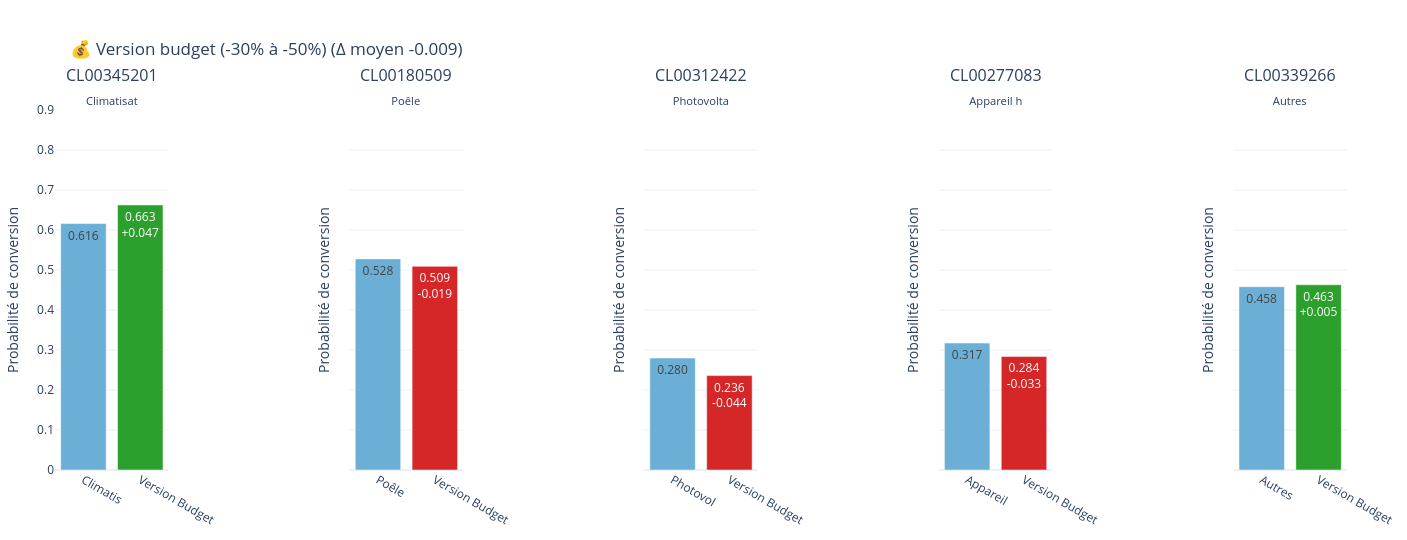

In [7]:
# Simulation
compute = get_budget_alternative_compute_function(model, feature_names, df_sim, selected_ids)
show_budget_alternative_widget(compute, selected_ids)